# Notebook utilised for processing results of CEC22 Manuscript 2494

This Jupyter Notebook process the results of the work entitled **A Primary Study on Hyper-Heuristics Powered by Artificial Neural Networks for Customising Population-based Metaheuristics in Continuous Optimisation Problems** presented in *CEC-22*.

Authors: _José Manuel Tapia-Avitia, Jorge M. Cruz-Duarte, Ivan Amaya, José Carlos Ortiz-Bayliss, Hugo Terashima Marín, Nelishia Pillay_

## General settings

### Modules

Let's import the modules that we would uses for process the results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import seaborn as sns
from mpmath import *
from decimal import Decimal

import tools as tl
import benchmark_func as bf

### Constants

A few constants to arrange the figures.

In [2]:
sns.set(context="paper", font_scale=1.8, palette="husl", style="ticks",
        rc={'font.family': 'serif', 'font.size': 18,
            "xtick.major.top": False, "ytick.major.right": False})
plt.rc('font', size=18) 

# Saving images flag
is_saving = True
show_plots = True
saving_format = 'png'

figures_folder = 'data_files/exp_figures/'
experiment_folder = 'data_files/exp_output'
if is_saving:
    # Read (or create if so) a folder for storing images
    if not os.path.isdir(figures_folder):
        os.mkdir(figures_folder)

## Experiment information

General information of the experiments

In [3]:
# Experiments names
data_files = dict({
    #'Bert': {
    #    'filename': 'demo_transformers_2bert',
    #    'ID': 'bert'
    #},
    #"Epochs": {
    #    "filename": "demo_transformers_epochs",
    #    "ID": "distilbert\_epochs"
    #},
    #'Distilbert': {
    #    'filename': 'demo_transformers',
    #    'ID': 'distilbert'
    #},
    "DLSTM": {
        "filename": "default_nn_lstm_double_sigmoid_new",
        "ID": "dlstm\_original"
    },
    "DLSTMnew": {
        "filename": "default_nn_best_double_lstm",
        "ID": "dlstm\_new"
    },
})

Retrieve 'default' collection (205 search operators) and the basic metaheuristic collection (66 MH configurations)

In [4]:
# Read operators and find their alias
collections = ['default.txt', 'basicmetaheuristics.txt']

encoded_heuristic_space = dict()
for collection_file in collections:
    with open('./collections/' + collection_file, 'r') as operators_file:
        encoded_heuristic_space[collection_file] = [eval(line.rstrip('\n')) for line in operators_file]

# Search operator aliases
perturbator_alias = {
    'random_search': 'RS',
    'central_force_dynamic': 'CF',
    'differential_mutation': 'DM',
    'firefly_dynamic': 'FD',
    'genetic_crossover': 'GC',
    'genetic_mutation': 'GM',
    'gravitational_search': 'GS',
    'random_flight': 'RF',
    'local_random_walk': 'RW',
    'random_sample': 'RX',
    'spiral_dynamic': 'SD',
    'swarm_dynamic': 'PS'}

selector_alias = {'greedy': 'g', 'all': 'd', 'metropolis': 'm', 'probabilistic': 'p'}

operator_families = {y: i for i, y in enumerate(sorted([x for x in perturbator_alias.values()]))}

# Pre-build the alias list
heuristic_space = dict()
for collection_file in collections:
    if all(isinstance(x, tuple) for x in encoded_heuristic_space[collection_file]):
        heuristic_space[collection_file] = [perturbator_alias[x[0]] + selector_alias[x[2]]
                                            for x in encoded_heuristic_space[collection_file]]

# Find repeated elements
for collection_file in collections:
    if collection_file in heuristic_space:
        for heuristic in heuristic_space[collection_file]:
            concurrences = tl.listfind(heuristic_space[collection_file], heuristic)
            if len(concurrences) > 1:
                for count, idx in enumerate(concurrences):
                    heuristic_space[collection_file][idx] += f'{count + 1}'

Pre-process results. Unzip the experiment results using the instructions of [README](./README.md) before continue.

In [5]:
# Number of dimensions
dimensions = [2, 10, 30, 50]
num_dims = len(dimensions)

def sort_dataset(dataset):
    # Sort the results of the 428 problems in lexicographically order
    list_pair_results = list(zip(dataset['problem'],
                                 dataset['dimensions'],
                                 dataset['results']))
    list_pair_results.sort()
    dataset['problem'], dataset['dimensions'], dataset['results'] = [], [], []
    for problem, dimension, result in list_pair_results:
        dataset['problem'].append(problem)
        dataset['dimensions'].append(dimension)
        dataset['results'].append(result)
        
def filter_by_dimensions(dataset):
    # Filter the dataset allowing only the dimensions from 'dimensions' list.
    # The usercase is for the basic metaheuristics that has results for extra 
    # dimensions out of scope of this paper.
    allowed_dim_inds = [index for d in dimensions for index in tl.listfind(dataset['dimensions'], d)]
    dict_filtered = {key: [val[x] for x in allowed_dim_inds] for key, val in dataset.items()}
    sort_dataset(dict_filtered)
    return dict_filtered

# Take the last element of a list or the last elements of a list of lists
last_elements = lambda seqs: seqs[-1] if type(seqs[0]) == float else [seq[-1] for seq in seqs] 

def success_comparison(experimentA, experimentB):
    # Compare the proportion of outperform between two experiments
    # The percentage is the proportion of cases where A outperform B
    performance_diff = [np.copy(x - np.array(y)) for x, y in zip(experimentA, experimentB)]
    if len(performance_diff[0].shape) == 0:
        # uMHs
        return [1 if x <= 0.0 else 0 for x in performance_diff]
    else:
        # bMHs
        return [np.sum(x <= 0.0) / len(x) for x in performance_diff]

## Processing results

### Basic Metaheuristics results

In [6]:
# Read basic metaheuristics
basic_mhs_collection = encoded_heuristic_space['basicmetaheuristics.txt']

# Read basic metaheuristics cardinality
basic_mhs_cadinality = [1 if isinstance(x, tuple) else len(x) for x in basic_mhs_collection]

# Load data from basic metaheuristics
basic_mhs_data = filter_by_dimensions(tl.read_json(f'{experiment_folder}/basic-metaheuristics-data_v2.json'))
basic_metaheuristics = basic_mhs_data['results'][0]['operator_id']

long_dimensions = basic_mhs_data['dimensions']
long_problems = basic_mhs_data['problem']

# Mathematical attributes
chosen_categories = ['Differentiable', 'Unimodal']
case_label = 'DU'

# Call the problem categories
problem_features = bf.list_functions(fts=chosen_categories)
categories = sorted(set([problem_features[x]['Code'] for x in basic_mhs_data['problem']]), reverse=True)
# Extra plot configurations
cmap = plt.get_cmap('tab20')
colour_cat = [cmap(i)[:-1] for i in np.linspace(0, 1, len(categories))]
colour_dim = [cmap(i)[:-1] for i in np.linspace(0, 1, len(dimensions))]

# Performance array
bMH_performance = [x['performance'] for x in np.copy(basic_mhs_data['results'])]

### Unfolded Metaheuristics results (Random Search)

In [7]:
# Obtain results of unfolded performances
temporal_data = tl.read_json(f'{experiment_folder}/unfolded_hhs_pop30.json')
data_frame = filter_by_dimensions(temporal_data)
uMH_pop30_performance = [x['performance'][-1] for x in data_frame['results']]

### Experiments results (LSTM)

In [8]:
# Retrive the results per experiment
data_tables = dict()
for experiment in data_files:
    # Experiment data
    filename = data_files[experiment]['filename']
    temporal_data = tl.read_json(f'{experiment_folder}/{filename}.json')
    data_frame = filter_by_dimensions(temporal_data)

    # Experiment performance
    best_pos_sequences = [np.argmin(last_elements(x['hist_fitness'])) for x in data_frame['results']]
    performance = [x['performance'] for x in data_frame['results']]

    # Experiment vs Literature
    success_rates_bMHs = success_comparison(performance, bMH_performance)
    success_rates_uMH30 = success_comparison(performance, uMH_pop30_performance)
    
    # Statistics
    hFitness = [last_elements(x['hist_fitness']) for x in data_frame['results']]

    # Further insights
    best_sequences = [x['encoded_solution'][best_sol] for x, best_sol in zip(data_frame['results'],
                                                                             best_pos_sequences)]
    cardinality = [len(x) for x in best_sequences]

    # Summary
    id = data_files[experiment]['ID']
    data_tables[id] = pd.DataFrame({
        'Dim': [str(x) for x in data_frame['dimensions']],
        'Pop': 30,
        'Problem': data_frame['problem'],
        'Cat': [problem_features[x]['Code'] for x in data_frame['problem']],
        'Performance': performance,
        'Steps': [x['rep'][-1] for x in data_frame['results']],
        'Cardinality': cardinality,
        'hFitness': hFitness,
        'successRate': success_rates_bMHs,
        'successRateUMH30': success_rates_uMH30,
    })
    
# Melt data in one table
full_table = pd.concat(data_tables, axis=0, names=['ID', 'RID']).reset_index(level=0)
full_table['Dim'] = full_table['Dim'].apply(lambda x: int(x))
full_table['Pop'] = full_table['Pop'].apply(lambda x: int(x))

full_table['Rank'] = full_table.groupby(by=['Dim', 'Problem'])['Performance'].rank(method='dense')
full_table['RankSR'] = full_table.groupby(by=['Dim', 'Problem'])['successRate'].rank(method='dense', ascending=False)
full_table['DimPop'] = full_table[['Dim', 'Pop']].agg(tuple, axis=1)

full_table = full_table.reset_index()

In [9]:
full_table[full_table["ID"] == "distilbert"]

,RID,ID,Dim,Pop,Problem,Cat,Performance,Steps,Cardinality,hFitness,successRate,successRateUMH30,Rank,RankSR,DimPop


In [10]:
full_table[full_table["ID"] == "bert"]

,RID,ID,Dim,Pop,Problem,Cat,Performance,Steps,Cardinality,hFitness,successRate,successRateUMH30,Rank,RankSR,DimPop


### Statistical analysis

#### Wilcoxon test

In [11]:
stats_results = dict()
wilcoxon_alternativies = ['two-sided', 'greater', 'less']
exp_ids = full_table['ID'].unique()
for exp_idA in exp_ids:
    perf_idA = list(data_tables[exp_idA]['Performance'])    
    # Experiments
    for exp_idB in exp_ids:
        perf_idB = list(data_tables[exp_idB]['Performance'])
        # Wilcoxon
        for alternative in wilcoxon_alternativies:
            if exp_idA != exp_idB:
                if perf_idA == perf_idB:
                    print(perf_idA)
                    print(exp_idA, exp_idB)
                    break
            _, p_value = st.wilcoxon(perf_idA, perf_idB, alternative=alternative) if exp_idA != exp_idB else (_, 1)
            stats_results[(exp_idA, exp_idB, 'wilcoxon', alternative)] = p_value
        # Percentage 
        percentage = success_comparison(perf_idA, perf_idB)
        stats_results[(exp_idA, exp_idB, 'percentage')] = np.mean(percentage)
    
    # Literature
    # uMH_pop30
    for alternative in wilcoxon_alternativies:
        _, p_value = st.wilcoxon(perf_idA, uMH_pop30_performance, alternative=alternative)
        stats_results[(exp_idA, 'unfolded\_mh\_pop30', 'wilcoxon', alternative)] = p_value

    # Basic MHs
    dict_basicMH_perf = dict({bMH: [] for bMH in basic_metaheuristics})
    for x in basic_mhs_data['results']:
        for bMH, y in zip(basic_metaheuristics, x['performance']):
            dict_basicMH_perf[bMH].append(y)
    for alternative in wilcoxon_alternativies:
        for exp_idB, perf_idB in dict_basicMH_perf.items():
            _, p_value = st.wilcoxon(perf_idA, perf_idB, alternative=alternative)    
            stats_results[(exp_idA, f'bMH_{exp_idB}', 'wilcoxon', alternative)] = p_value


[0.0014553425883558901, 2.532294834034974, 12.004733846714707, 18.237946881250114, -3.297860823100641, -9.103575084848483, 78.53543888315545, 243.19518034090527, 0.00012952065024450407, 0.060557334069515176, 8.40025774496712, 17.08078655291485, -6.129503871594514, -760.8570032959551, 26458015635.13994, 9.62334361587497e+16, 7.287665379496211e-08, 2.275792809402692, 48.70346570528282, 269.6896245530782, 1.3649262425028126e-08, 0.0017541442215380093, 3.28399698018866, 40.45765116580205, 8.560045570213389e-11, 0.00011097757289637891, 4.204999116777282, 60.05124538433354, -24.156815543738272, -867668.0511733115, -378203493362.2686, -80824277017404.0, 2.0126168211306925e-18, 0.008718367767783754, 127540.71271722091, 11445959.274740722, 1.1145910438494469e-06, 48638.54439579909, 277585859.7103145, 3429132672.6132584, -2.2, -11.0, -33.0, -55.0, -2.0626118615631603, -1.5565154065101616, -0.5654985789155987, -0.20918026616503693, -0.001821036461360337, -1.0, -1.0, -1.0, 0.05435131911201631, 0.0

## Plots

### Percentage of winning per dimension

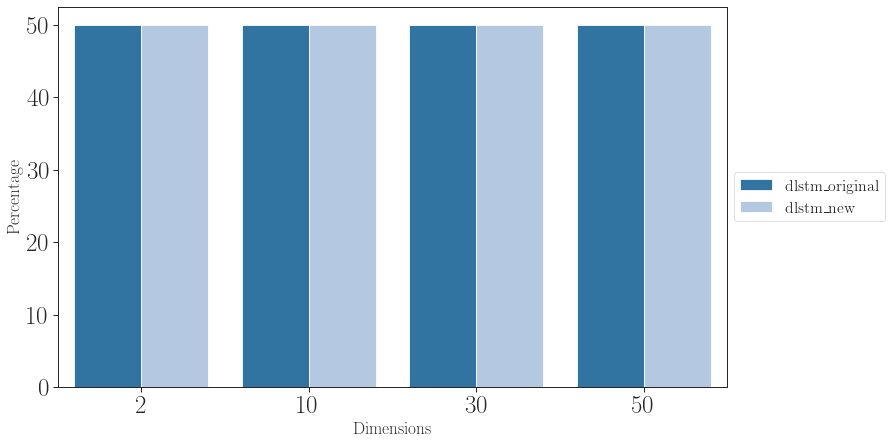

In [12]:
exp_ids = full_table['ID'].unique()
exp_dims = full_table['Dim'].unique()

exp_ids_list, exp_dims_list, exp_cnt_list = [], [], []
for exp_id in exp_ids:
    for exp_dim in exp_dims:
        exp_ids_list.append(exp_id)
        exp_dims_list.append(exp_dim)
        cnt = ((full_table['ID'] == exp_id) & (full_table['Dim'] == exp_dim) & (full_table['Rank'] == 1)).sum()
        exp_cnt_list.append(cnt)
best_table_rank = pd.DataFrame({'ID': exp_ids_list, 'Dim': exp_dims_list, 'Count': exp_cnt_list})

sums_dim = dict()
for exp_dim in exp_dims:
    exp_indices = (best_table_rank['Dim'] == exp_dim)
    sums_dim[exp_dim] = best_table_rank[exp_indices]['Count'].sum()
        
best_table_rank_dim = best_table_rank.copy()
for idx in best_table_rank_dim.index:
    exp_row = best_table_rank_dim.iloc[idx]
    best_table_rank_dim.loc[idx, 'Count'] = 100*exp_row['Count'] / sums_dim[exp_row['Dim']]

fig, ax = plt.subplots(figsize=(12,7))

p_1_winner = sns.barplot(data=best_table_rank_dim, x='Dim', y='Count', hue='ID', palette='tab20')
plt.legend(bbox_to_anchor=(1.01,0.5), loc="center left", borderaxespad=0)
p_1_winner.set_xlabel('Dimensions')
p_1_winner.set_ylabel('Percentage')
fig.subplots_adjust()
plt.rc('legend',fontsize=23)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.rcParams['axes.labelsize'] = 40
plt.rcParams['axes.titlesize'] = 38

if is_saving:
    plt.savefig(figures_folder + 'Rank_Winner_dim.' + saving_format,
               format=saving_format, dpi=333, bbox_inches="tight", transparent=True)
if show_plots:
    plt.show()

### Success against bMH and RS

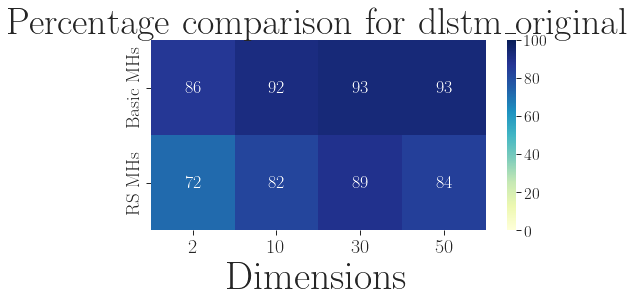

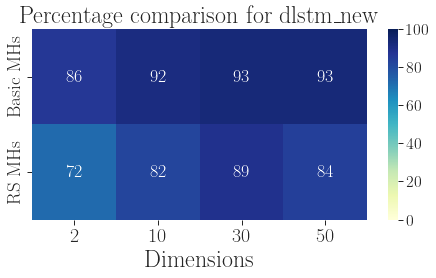

In [13]:
# Comparison of experiments against basic MH and uMH30
success_table_basic = full_table.groupby(['ID', 'Dim'])['successRate'].mean()
success_table_uMH30 = full_table.groupby(['ID', 'Dim'])['successRateUMH30'].mean()
table_bydim_basic = success_table_basic.reset_index().set_index('Dim')
table_bydim_uMH30 = success_table_uMH30.reset_index().set_index('Dim')

exp_ids_dict = dict()
exp_avgs_dict = dict({
    'Basic MHs': [],
    'RS MHs': []
})
for exp_id in exp_ids:
    # Retrieve rates
    exp_ids_dict['Basic MHs'] = list(table_bydim_basic[table_bydim_basic['ID'] == exp_id]['successRate']*100) 
    exp_ids_dict['RS MHs'] = list(table_bydim_uMH30[table_bydim_uMH30['ID'] == exp_id]['successRateUMH30']*100) 

    avg_mh = np.average(exp_ids_dict['Basic MHs'])
    avg_rs = np.average(exp_ids_dict['RS MHs'])
    exp_avgs_dict['Basic MHs'].append(avg_mh)
    exp_avgs_dict['RS MHs'].append(avg_rs)
    # Convert to DF
    df_exp = pd.DataFrame(exp_ids_dict, index=exp_dims)
    df_exp = df_exp.rename_axis('Dimensions')
    df_exp = df_exp.T
    # Plot
    fig, ax = plt.subplots(figsize=(7.5,3.5))
    fig.subplots_adjust()
    sns.heatmap(df_exp, vmin=0, vmax=100, annot=True,  cmap="YlGnBu")
    plt.title(f'Percentage comparison for {exp_id}')
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['axes.titlesize'] = 24
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=19)

    if is_saving:
        id_text = exp_id.replace('\\', '')
        plt.savefig(figures_folder  +  f'{id_text}_Percentage_cmp_BMH_UMH30.' + saving_format,
                format=saving_format, dpi=333, bbox_inches="tight", transparent=True)
    if show_plots:
        plt.show()

### Overall percentage against literature

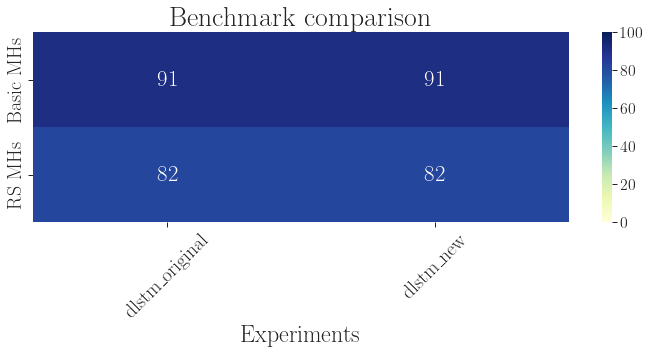

In [14]:
# Experiments vs Literature

# Dataframe
df_exps = pd.DataFrame(exp_avgs_dict, index=exp_ids)
df_exps = df_exps.rename_axis('Experiments')
# Plot
fig, ax = plt.subplots(figsize=(12,3.5))
plt.rc('font', size=23)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.titlesize'] = 28
sns.heatmap(df_exps.T, vmin=0, vmax=100, annot=True,  cmap="YlGnBu")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
fig.subplots_adjust()
plt.title(f'Benchmark comparison')

if is_saving:
    plt.savefig(figures_folder  +  f'cmp_BMH_UMH30.' + saving_format,
            format=saving_format, dpi=333, bbox_inches="tight", transparent=True)
if show_plots:
    plt.show()

### Wilcoxon test (per experiment)

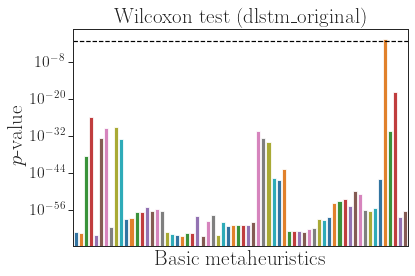

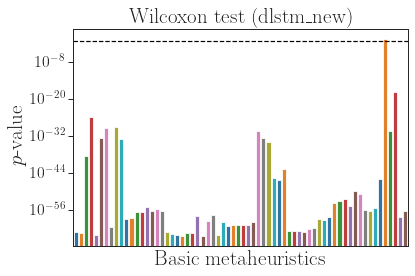

In [15]:
# Wilcoxon test (Alternative: Less)
p_value = 0.05

plt.rc('font', size=18)     
plt.rcParams['axes.labelsize'] = 21
plt.rcParams['axes.titlesize'] = 21

for exp_id in exp_ids:
    # Dataframe
    p_values_bMHs = [stats_results[(exp_id, f'bMH_{bMH}', 'wilcoxon', 'less')]
                     for bMH in basic_metaheuristics]
    df_pvalues = pd.DataFrame({'Basic MH': basic_metaheuristics,
                               'p-value': p_values_bMHs })
    # Plot
    fig, ax = plt.subplots(figsize=(6,4))
    fig.subplots_adjust()
    barplottt = sns.barplot(x=df_pvalues['Basic MH'], y=df_pvalues['p-value'], palette='tab10')
    ax.axhline(y=p_value, color='black', linestyle='--')
    barplottt.set_yscale('log')
    barplottt.set(xticks=[])
    ax.set_xlabel('Basic metaheuristics')
    ax.set_ylabel('$p$-value')
    ax.set_title(f"Wilcoxon test ({exp_id})")
    id_text = exp_id.replace('\\', '')

    if is_saving:
        plt.savefig(figures_folder +  f'{id_text}_pvalue_log_scale.' + saving_format,
                format=saving_format, dpi=333, bbox_inches="tight", transparent=True)
    if show_plots:
        plt.show()

### Wilcoxon results - Raw p-values vs literature

In [16]:
# Comparison against uMH30 
for exp_id in exp_ids:
    print(f'Experiment {exp_id} vs uMH30; pvalue = ', stats_results[(exp_id, 'unfolded\_mh\_pop30', 'wilcoxon', 'less')])
print()

# Multicomparison against bMHs
for exp_id in exp_ids:
    p_values_bMHs = [stats_results[(exp_id, f'bMH_{bMH}', 'wilcoxon', 'less')]
                     for bMH in basic_metaheuristics]  
    p_values_bMHs = [mpf(pvalue) for pvalue in p_values_bMHs]
    p_value_mix = 1 - np.prod(1 - np.array(p_values_bMHs))
    print(f'Experiment {exp_id} vs bMHs; pvalue = ', round(p_value_mix, 20))

Experiment dlstm\_original vs uMH30; pvalue =  3.3709501936821734e-31
Experiment dlstm\_new vs uMH30; pvalue =  3.3709501936821734e-31

Experiment dlstm\_original vs bMHs; pvalue =  0.2971258201599082
Experiment dlstm\_new vs bMHs; pvalue =  0.2971258201599082


### Wilcoxon matrix (partial order)

KeyError: ('dlstm\\_original', 'dlstm\\_new', 'wilcoxon', 'two-sided')

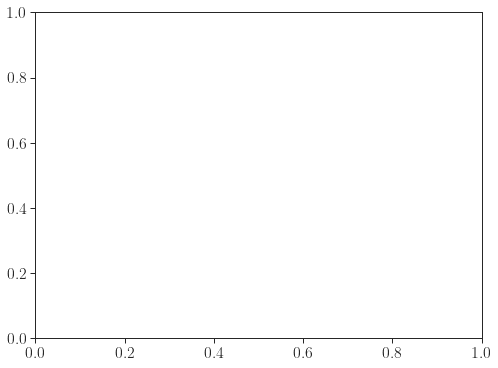

In [17]:
# Wilcoxon between exp_ids (all alternativies)
colors_alt = dict({
    'two-sided': 'Greens',
    'less': 'Reds',
    'greater': 'Blues'
})
for alternative in wilcoxon_alternativies:
    fig, ax = plt.subplots(figsize=(8,6))
    plt.rc('font', size=18)

    fig.subplots_adjust()
    dict_comparison = dict()

    for exp_idA in exp_ids:
        p_values_B = [stats_results[(exp_idA, exp_idB, 'wilcoxon', alternative)]
                        for exp_idB in exp_ids]
        dict_comparison[exp_idA] = [round(pvalue, 2) for pvalue in p_values_B]

    df_comparison = pd.DataFrame(dict_comparison, index=exp_ids)
    sns.heatmap(df_comparison, vmin=0, vmax=1, annot=True,  cmap=colors_alt[alternative])
    ax.set_title(f'Alternative: {alternative}')
    ax.set_xlabel('$B$')
    ax.set_ylabel('$A$')
    if is_saving:
        plt.savefig(figures_folder + f'wilcoxon_all_pairs_{alternative}.' + saving_format,
                format=saving_format, dpi=333, bbox_inches="tight", transparent=True)
    if show_plots:
        plt.show()


### Winners per category

In [1]:
# Comparison of winners per category 
rank_1 = full_table['Rank'] == 1
table_rank_1 = full_table[rank_1]
plt.rc('font', size=18)

plt_sns = sns.catplot(data=table_rank_1, hue='ID', x='Rank',
                      row='Cat',  col='Dim', kind='count', 
                      height=3.5, aspect=0.8, legend=True,
                      palette='tab20', margin_titles=True)
plt_sns.set(xlabel=None).set(xticklabels=[])
plt_sns.set_ylabels('Count')

plt.rc('legend',fontsize=20)
plt.yticks(fontsize=24)
plt.rcParams['axes.labelsize'] = 30

if is_saving:
    plt.savefig(figures_folder + 'Rank_vs_Id_and_Dim_Cat-BestRanked.' + saving_format,
               format=saving_format, dpi=333, bbox_inches="tight", transparent=True)

if show_plots:
    plt.show()

NameError: name 'full_table' is not defined

## Additional plots

### Collection plot

In [ ]:
default_heuristic_space = encoded_heuristic_space['default.txt']

mh_so = [mh.replace('_', '\_') for mh, _, _ in default_heuristic_space]
sel_so= [sel.replace('_', '\_') for _, _, sel in default_heuristic_space]
df_default = pd.DataFrame({'Metaheuristic': mh_so, 'Selector': sel_so})


fig, ax = plt.subplots(figsize=(12,6))
fig.subplots_adjust()
plt.rc('font', size=18) 
so_dist = sns.countplot(data=df_default, x='Metaheuristic', hue='Selector', ax=ax, palette='tab10')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
so_dist.set_xlabel(r'Basic metaheuristic search operators')
so_dist.set_ylabel(r'Number of search operators')

if is_saving:
    plt.savefig(figures_folder + 'search_operators_collection_default.' + saving_format,
               format=saving_format, dpi=333, bbox_inches="tight", transparent=True)
if show_plots:
    plt.show()

### Wilcoxon test - Multicomparison of basic metaheuristics per experiment

In [ ]:
plt.rcParams['axes.labelsize'] = 21
plt.rcParams['axes.titlesize'] = 21
mp.dps = 1e3

for exp_id in exp_ids:
    p_values_bMHs = [stats_results[(exp_id, f'bMH_{bMH}', 'wilcoxon', 'less')]
                     for bMH in basic_metaheuristics]
    p_values_bMHs.sort()

    acum = mpf(1)
    join_pval = []
    for p_value in p_values_bMHs:
        acum *= 1 - mpf(p_value)
        join_pval.append(float(1 - acum))
    
    # Plot
    fig, ax = plt.subplots(figsize=(6,4))
    fig.subplots_adjust()
    barplottt = sns.barplot(x=basic_metaheuristics, y=join_pval, palette='tab10')
    ax.axhline(y=0.05, color='black', linestyle='--')
    barplottt.set_yscale('log')
    barplottt.set(xticks=[])
    ax.set_xlabel('Basic metaheuristics')
    ax.set_ylabel('$p$-value')
    ax.set_title(f"Wilcoxon test ({exp_id})")
    id_text = exp_id.replace('\\', '')
    
    
    if is_saving:
        plt.savefig(figures_folder +  f'{id_text}_groups_wilcoxon.' + saving_format,
                format=saving_format, dpi=333, bbox_inches="tight", transparent=True)
    if show_plots:
        plt.show()


### Cardinality of sequences

In [ ]:
sns.displot(data=full_table, hue='ID', col='Dim', x='Cardinality', kind='kde', palette='tab10', height=3.5,
            aspect=0.8, fill=True)

if is_saving:
    plt.savefig(figures_folder + 'Card_vs_Dim_Id-KDE.' + saving_format, format=saving_format, dpi=333, bbox_inches="tight", transparent=True)
if show_plots:
    plt.show()